# Tarea 2 ML ZoomCamp #

In [7]:
# importar librerias #
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import wget

In [8]:
# Descargar la data de internet #
url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv'
filename = wget.download(url)
df_data=pd.read_csv(filename)
print(df_data.shape)
df_data.head()

 69% [...................................................                       ]  991232 / 1423529

100% [..........................................................................] 1423529 / 1423529(20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### EDA ###
Load the data.

Look at the median_house_value variable. Does it have a long tail?

<AxesSubplot:xlabel='median_house_value', ylabel='Count'>

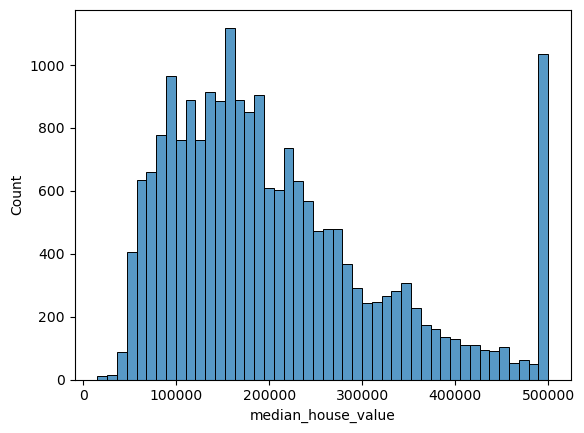

In [9]:
sns.histplot(df_data['median_house_value'])

In [10]:
features=['latitude',
'longitude',
'housing_median_age',
'total_rooms',
'total_bedrooms',
'population',
'households',
'median_income',
'median_house_value']

# Pregunta 1:#

Find a feature with missing values. How many missing values does it have?

In [11]:
df_data_filter=df_data[features]
df_data_filter.isna().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

# Pregunta 2: #

What's the median (50% percentile) for variable 'population'?

In [12]:
df_data_filter['population'].median()

1166.0

# Pregunta 3: #

Best way to fill nan values?

In [14]:
# Separar el dataset #
np.random.seed(2)

n = len(df_data_filter)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)

np.random.shuffle(idx)

len(idx)

20640

In [15]:
# Seleccionar registros aleatoriamente #

df_shuffled = df_data_filter.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

print (df_train.shape,df_val.shape,df_test.shape)

(12384, 9) (4128, 9) (4128, 9)


In [16]:
# Seleccionar la variable target # 

y_train_orig = df_train.median_house_value.values
y_val_orig = df_val.median_house_value.values
y_test_orig = df_test.median_house_value.values

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [19]:
# Definir funcion entrenamiento regresion lineal #
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])  
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [20]:
# Definir funcion para tratamiento del dataset #
base=df_train.columns.tolist()

def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

def prepare_X_2(df):
    df_num = df[base]
    for col in base:
        df_num[col] = df_num[col].fillna(df_train[col].mean())
    X = df_num.values
    return X

In [47]:
# Definir funcion calculo RMSE #
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [22]:
# Calculo RSME para valores nulos = 0 #

X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)
X_val=prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
rmse(y_val, y_pred)

0.3320912318844027

In [23]:
# Calculo RSME para valores nulos = media #

X_train = prepare_X_2(df_train)
w_0, w = train_linear_regression(X_train, y_train)
X_val=prepare_X_2(df_val)
y_pred = w_0 + X_val.dot(w)
rmse(y_val, y_pred)

0.3316264681440004

# Pregunta 4: #

Best regularization parameter r

In [24]:
# Definir posibles valores de r #
r=[0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]

In [25]:
# Definir funcion regresion lineal con regularizacion #

def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [29]:
rmse_results=[]

for value in r:
    
    w_0, w = train_linear_regression_reg(X_train, y_train,value)
    y_pred=w_0 + X_val.dot(w)
    rmse_results.append({value:round(rmse(y_val, y_pred),2)})
   
print(rmse_results)

[{0: 0.33}, {1e-06: 0.33}, {0.0001: 0.33}, {0.001: 0.33}, {0.01: 0.33}, {0.1: 0.33}, {1: 0.34}, {5: 0.34}, {10: 0.34}]


# Pregunta 5 #

STD of RMSE scores for different seeds

In [30]:
seeds=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [43]:
rmse_results=[]
for seed in seeds:
    np.random.seed(seed)
    idx = np.arange(n)
    np.random.shuffle(idx)

    # Seleccionar registros aleatoriamente #

    df_shuffled = df_data_filter.iloc[idx].copy()

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()
    
    # Seleccionar la variable target # 

    y_train_orig = df_train.median_house_value.values
    y_val_orig = df_val.median_house_value.values
    y_test_orig = df_test.median_house_value.values

    y_train = np.log1p(df_train.median_house_value.values)
    y_val = np.log1p(df_val.median_house_value.values)
    y_test = np.log1p(df_test.median_house_value.values)

    del df_train['median_house_value']
    del df_val['median_house_value']
    del df_test['median_house_value']


    # Calculo RSME para valores nulos = 0 #

    X_train = prepare_X(df_train)
    w_0, w = train_linear_regression(X_train, y_train)
    X_val=prepare_X(df_val)
    y_pred = w_0 + X_val.dot(w)
    rmse_results.append(rmse(y_val, y_pred))


In [40]:
# Calcular desviación estandar #

std=round(np.std(rmse_results),3)
std

0.004

# Pregunta 6: #

In [48]:
np.random.seed(9)
idx = np.arange(n)
np.random.shuffle(idx)

# Seleccionar registros aleatoriamente #

df_shuffled = df_data_filter.iloc[idx].copy()

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()
df_train_val=pd.concat([df_train,df_val])

# Seleccionar la variable target # 

y_train_orig = df_train.median_house_value.values
y_val_orig = df_val.median_house_value.values
y_train_val_orig=df_train_val.median_house_value.values
y_test_orig = df_test.median_house_value.values

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_train_val=np.log1p(df_train_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']
del df_train_val['median_house_value']


# Calculo RSME para valores nulos = 0 #

X_train_val = prepare_X(df_train_val)
w_0, w = train_linear_regression_reg(X_train_val, y_train_val,r=0.001)
X_test=prepare_X(df_test)
y_pred = w_0 + X_test.dot(w)
rmse_result=rmse(y_test, y_pred)
rmse_result

0.34531689143895133